## Segmentación de clientes

## Librerías

In [1]:
# Librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para manipulación y análisis de datos
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from toolbox_DS import *

import warnings
warnings.filterwarnings('ignore')
pd.option_context('mode.use_inf_as_na', True)


## Carga de datos (train_set)

In [2]:
train_set = pd.read_csv('./data/train_set.csv')
train_set

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Response,income_missing,age,customes_seniority,Household_members,Total_amount,Total_purchase,Median_amount_purchase,Total_cmp,Total_%_cmp
0,5675,1960,PhD,Divorced,50611.0,0,1,2012-10-04,98,459,...,0,0,55,3,2.0,493,22,22.409091,1,0.2
1,5543,1966,Graduation,Together,57811.0,0,1,2013-06-24,49,545,...,0,0,49,2,3.0,802,25,32.080000,1,0.2
2,3011,1965,Graduation,Married,69139.0,0,1,2014-01-27,23,86,...,0,0,50,1,3.0,227,11,20.636364,0,0.0
3,535,1987,Graduation,Divorced,81361.0,0,0,2014-02-25,18,163,...,0,0,28,1,1.0,778,27,28.814815,0,0.0
4,10755,1976,2n Cycle,Married,23718.0,1,0,2013-09-02,76,6,...,0,0,39,2,3.0,81,9,9.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785,5320,1973,Master,Divorced,44051.0,1,1,2013-01-29,20,79,...,1,0,42,2,3.0,171,12,14.250000,0,0.0
1786,2894,1985,Graduation,Single,72903.0,0,0,2013-10-29,74,1067,...,1,0,30,2,1.0,2013,21,95.857143,3,0.6
1787,1726,1970,Graduation,Single,22585.0,0,0,2013-03-18,23,3,...,1,0,45,2,1.0,81,5,16.200000,1,0.2
1788,6905,1994,Graduation,Together,80685.0,0,0,2012-08-22,55,241,...,0,0,21,3,2.0,1004,21,47.809524,0,0.0


In [3]:
train_set.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'income_missing', 'age',
       'customes_seniority', 'Household_members', 'Total_amount',
       'Total_purchase', 'Median_amount_purchase', 'Total_cmp', 'Total_%_cmp'],
      dtype='object')

In [4]:
# Cambio el índice
train_set.set_index('ID', inplace=True)

# Cambio tipo a datetime
train_set['Dt_Customer'] = pd.to_datetime(train_set['Dt_Customer'])

# Cambiar tipo a categóricas
cols_to_category = ['Education', 'Marital_Status']
train_set[cols_to_category] = train_set[cols_to_category].astype('category')

# Elimino columna 'income_missing'
train_set = train_set.drop(columns=['income_missing', 'Year_Birth','Total_%_cmp','Dt_Customer','Median_amount_purchase'])

# Elimino el outlier de Income
train_set = train_set.loc[train_set['Income'] !=666666]

## Tratamiento de variables

Selección de features por dtype

In [5]:
features_num = train_set.select_dtypes(['int','float']).columns
features_cat = train_set.select_dtypes(['object', 'category']).columns
print('features_num', features_num)
print('features_cat', features_cat)

features_num Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'age', 'customes_seniority',
       'Household_members', 'Total_amount', 'Total_purchase', 'Total_cmp'],
      dtype='object')
features_cat Index(['Education', 'Marital_Status'], dtype='object')


Preparación de las transformaciones

In [6]:
# Definimos el OrdinalEncoder con el mapeo de 'education_ode'
ordinal_encoder = OrdinalEncoder(categories=[['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']])

categorical_features_onehot = ['Marital_Status']
categorical_features_ordinal = ['Education']
numerical_features = features_num

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat_onehot', OneHotEncoder(), categorical_features_onehot),
        ('cat_ordinal', Pipeline([
            ('ordinal', ordinal_encoder),
            ('scaler', MinMaxScaler())
        ]), categorical_features_ordinal)
    ]
)

Primera valoración del KMeans con un rango entre 3 y 7 clúster

In [7]:
soluciones = list(range(3, 7))

codo = []
silueta = []
calins = []
davies = []

for solucion in soluciones:
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('kmeans', KMeans(random_state=42, n_clusters=solucion, n_init=10))
    ])
    
   
    pipeline.fit(train_set)
    
    # Obtenemos los datos transformados del paso 'preprocessor'
    X_transformed = pipeline.named_steps['preprocessor'].transform(train_set)
    
    # Obtenemos las etiquetas del cluster del paso 'kmeans'
    labels = pipeline.named_steps['kmeans'].labels_
    
    # Recoger las métricas usando los datos transformados
    codo.append(pipeline.named_steps['kmeans'].inertia_)
    silueta.append(silhouette_score(X_transformed, labels))
    calins.append(calinski_harabasz_score(X_transformed, labels))
    davies.append(davies_bouldin_score(X_transformed, labels))

Resultados a dataframe y visualización gráfica

In [8]:
metricas = pd.DataFrame({'Solucion':soluciones,
              'Codo': codo,
              'Silueta':silueta,
              'Calins':calins,           
              'Davies':davies}).set_index('Solucion')

metricas

,Codo,Silueta,Calins,Davies
Solucion,,,,
3,1.516855e+11,0.543002,4077.848251,0.554045
4,1.019887e+11,0.528716,4330.924292,0.567650
5,6.659411e+10,0.536339,5208.929714,0.461499
6,4.426192e+10,0.535167,6445.987266,0.461466


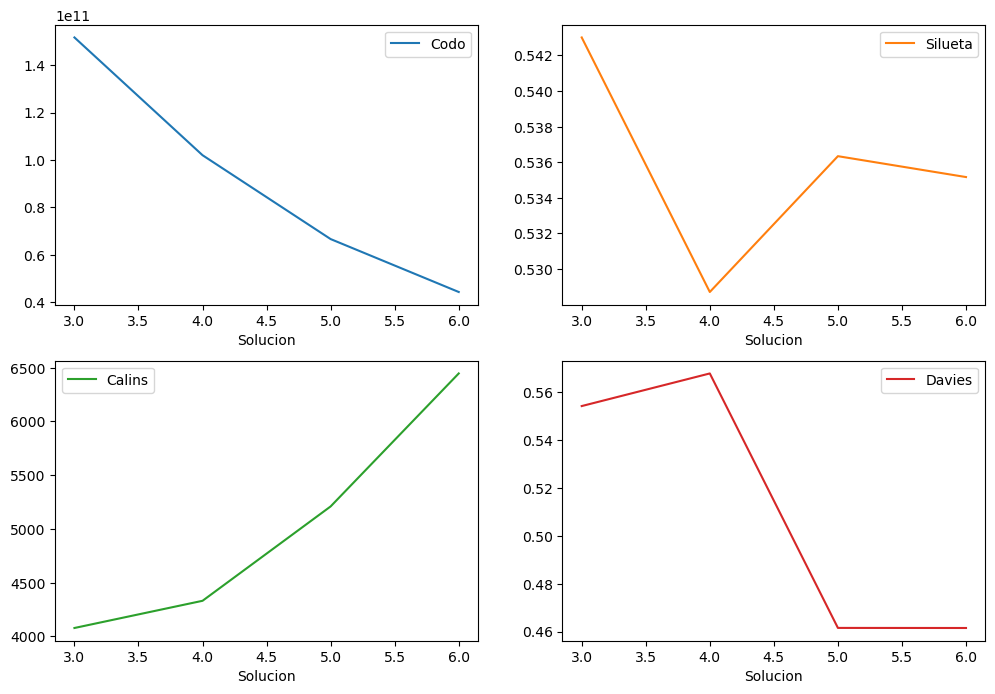

In [9]:
metricas.plot(subplots = True, figsize = (12,8), layout = (2,2), sharex = False);

Parece que estaría entre 4 y 5 sería el mejor número para los clúster.

In [10]:
# Instanciar el pipeline con el preprocesador y KMeans
pipeline = Pipeline(steps=[
       ('preprocessor', preprocessor),
       ('kmeans', KMeans(random_state=42, n_clusters=4, n_init=10))
   ])
    
# Entrenar el pipeline
pipeline.fit(train_set)
    
# Obtenemos los datos transformados del paso 'preprocessor'
X_transformed = pipeline.named_steps['preprocessor'].transform(train_set)
    
# Obtenemos las etiquetas del cluster del paso 'kmeans'
labels = pipeline.named_steps['kmeans'].labels_

# Si deseas añadir las etiquetas de los clusters al DataFrame original
train_set['Cluster'] = labels

In [11]:
train_set['Cluster'].value_counts()

Cluster
3    551
1    538
2    381
0    319
Name: count, dtype: int64

Elijo 4 dado que con 5 se me queda un último clúster muy pequeño (solo 7 personas)

## Análisis clúster con respecto a las variables

### Análisis con variables numéricas

Análisis de Income vs Cluster
****************************************


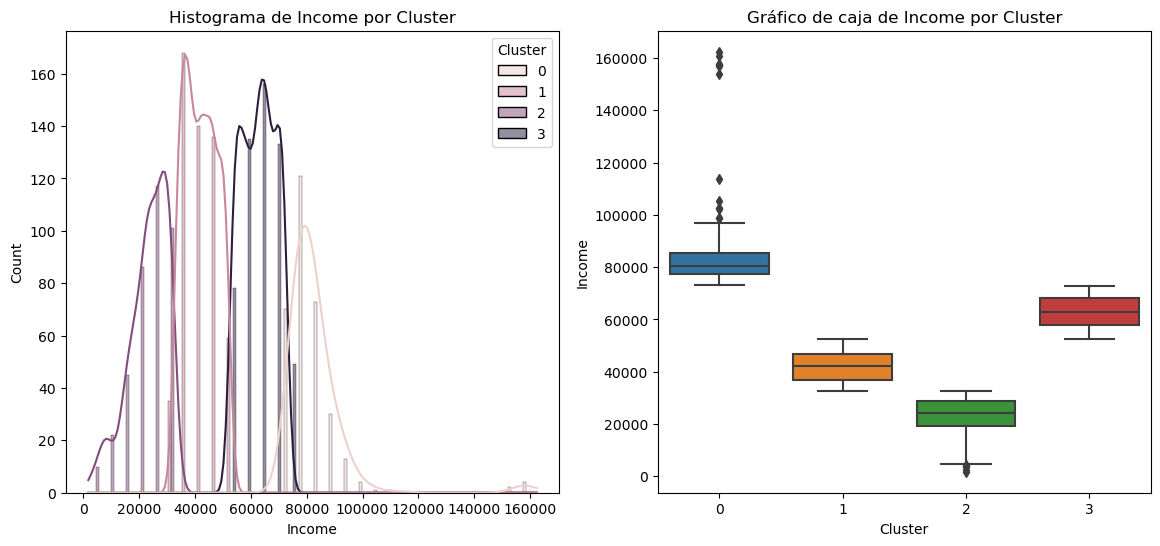

Estadísticos de resumen para Income por Cluster:
         count      mean       std      min      25%      50%      75%  \
Cluster                                                                  
0        319.0  83115.62  12126.59  73059.0  77261.5  80589.0  85251.5   
1        538.0  42045.16   5685.35  32727.0  36968.5  42012.5  46723.5   
2        381.0  23259.97   6909.78   1730.0  19107.0  24336.0  28691.0   
3        551.0  62861.23   5932.39  52513.0  57718.0  62998.0  68001.5   

              max  
Cluster            
0        162397.0  
1         52413.0  
2         32644.0  
3         72967.0  

ANOVA para Income:
Estadístico F: 4343.22
p-valor: 0.000
La variable Income está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de Kidhome vs Cluster
****************************************


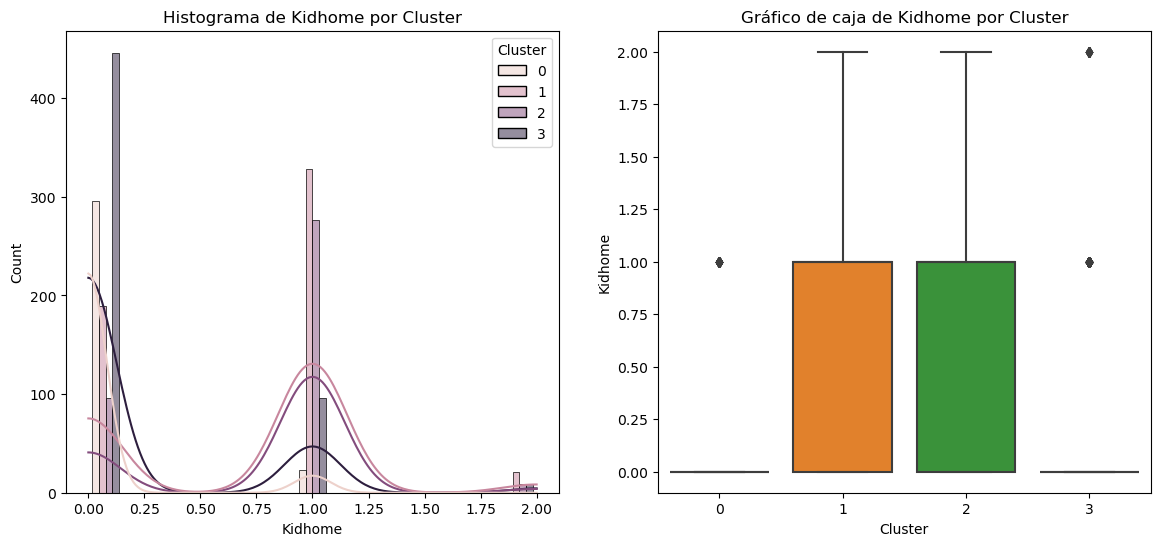

Estadísticos de resumen para Kidhome por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        319.0  0.07  0.26  0.0  0.0  0.0  0.0  1.0
1        538.0  0.69  0.54  0.0  0.0  1.0  1.0  2.0
2        381.0  0.77  0.47  0.0  0.0  1.0  1.0  2.0
3        551.0  0.21  0.44  0.0  0.0  0.0  0.0  2.0

ANOVA para Kidhome:
Estadístico F: 236.34
p-valor: 0.000
La variable Kidhome está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de Teenhome vs Cluster
****************************************


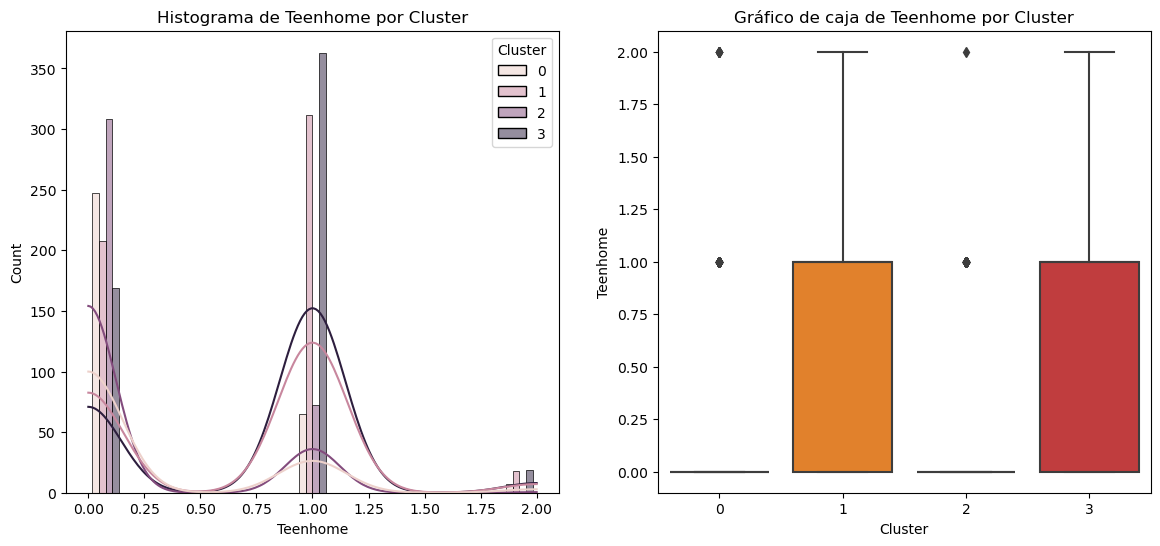

Estadísticos de resumen para Teenhome por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        319.0  0.25  0.48  0.0  0.0  0.0  0.0  2.0
1        538.0  0.65  0.54  0.0  0.0  1.0  1.0  2.0
2        381.0  0.19  0.40  0.0  0.0  0.0  0.0  2.0
3        551.0  0.73  0.52  0.0  0.0  1.0  1.0  2.0

ANOVA para Teenhome:
Estadístico F: 129.61
p-valor: 0.000
La variable Teenhome está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de Recency vs Cluster
****************************************


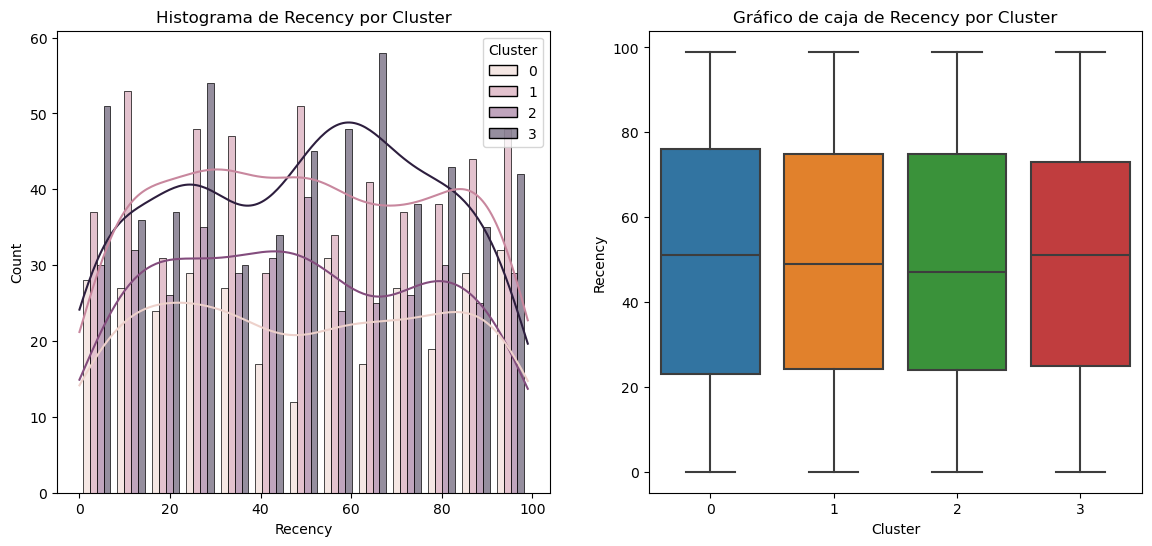

Estadísticos de resumen para Recency por Cluster:
         count   mean    std  min    25%   50%   75%   max
Cluster                                                   
0        319.0  49.39  30.29  0.0  23.00  51.0  76.0  99.0
1        538.0  49.43  29.04  0.0  24.25  49.0  75.0  99.0
2        381.0  48.14  28.43  0.0  24.00  47.0  75.0  99.0
3        551.0  49.15  28.63  0.0  25.00  51.0  73.0  99.0

ANOVA para Recency:
Estadístico F: 0.17
p-valor: 0.916
La variable Recency no está significativamente asociada con Cluster (p >= 0.05).

Análisis de MntWines vs Cluster
****************************************


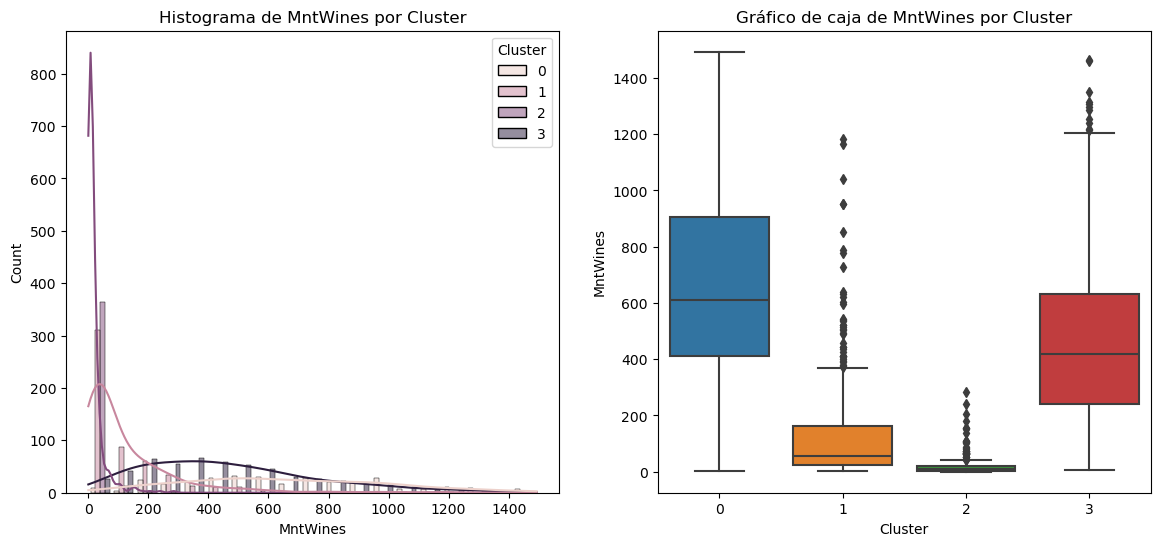

Estadísticos de resumen para MntWines por Cluster:
         count    mean     std  min    25%    50%     75%     max
Cluster                                                          
0        319.0  657.19  340.29  1.0  410.0  611.0  904.50  1493.0
1        538.0  122.57  164.58  2.0   23.0   57.0  162.75  1181.0
2        381.0   18.92   32.01  0.0    4.0    9.0   19.00   284.0
3        551.0  471.38  292.66  5.0  242.0  418.0  630.00  1462.0

ANOVA para MntWines:
Estadístico F: 625.33
p-valor: 0.000
La variable MntWines está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de MntFruits vs Cluster
****************************************


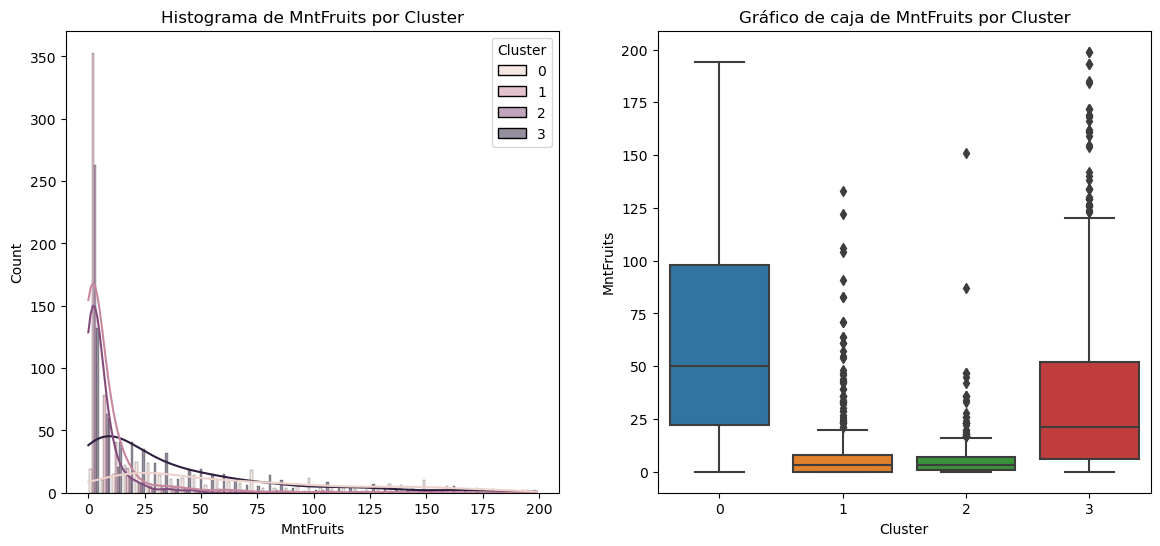

Estadísticos de resumen para MntFruits por Cluster:
         count   mean    std  min   25%   50%   75%    max
Cluster                                                   
0        319.0  63.93  50.65  0.0  22.0  50.0  98.0  194.0
1        538.0   7.92  15.68  0.0   0.0   3.0   8.0  133.0
2        381.0   6.04  11.41  0.0   1.0   3.0   7.0  151.0
3        551.0  36.16  42.17  0.0   6.0  21.0  52.0  199.0

ANOVA para MntFruits:
Estadístico F: 254.10
p-valor: 0.000
La variable MntFruits está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de MntMeatProducts vs Cluster
****************************************


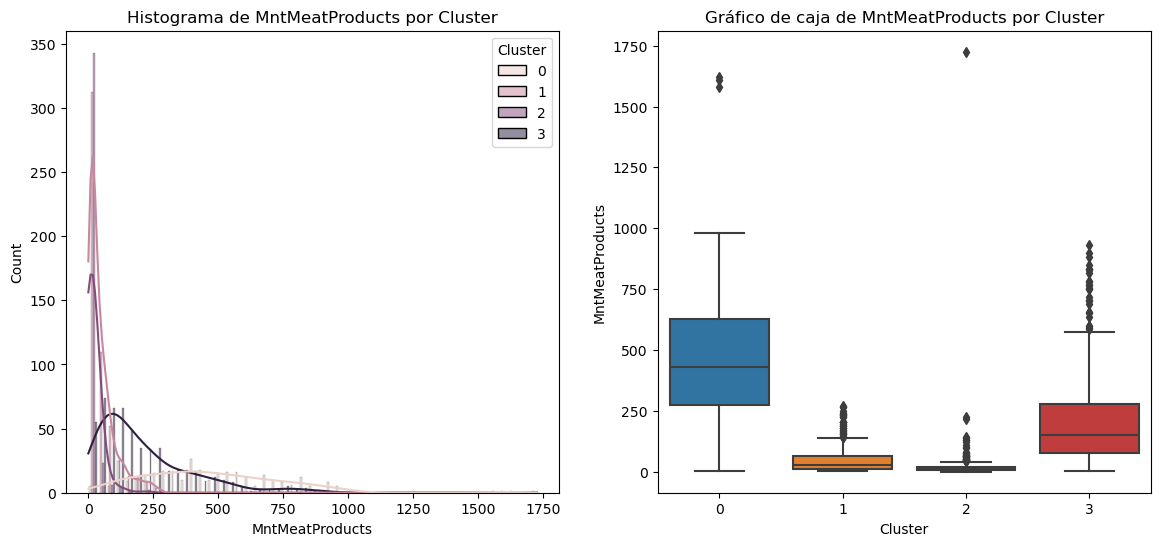

Estadísticos de resumen para MntMeatProducts por Cluster:
         count    mean     std  min    25%    50%     75%     max
Cluster                                                          
0        319.0  466.49  261.59  1.0  275.0  430.0  627.00  1622.0
1        538.0   46.98   52.17  1.0   12.0   26.0   62.75   271.0
2        381.0   23.03   91.05  0.0    7.0   11.0   20.00  1725.0
3        551.0  208.03  181.40  3.0   75.5  151.0  278.50   932.0

ANOVA para MntMeatProducts:
Estadístico F: 604.56
p-valor: 0.000
La variable MntMeatProducts está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de MntFishProducts vs Cluster
****************************************


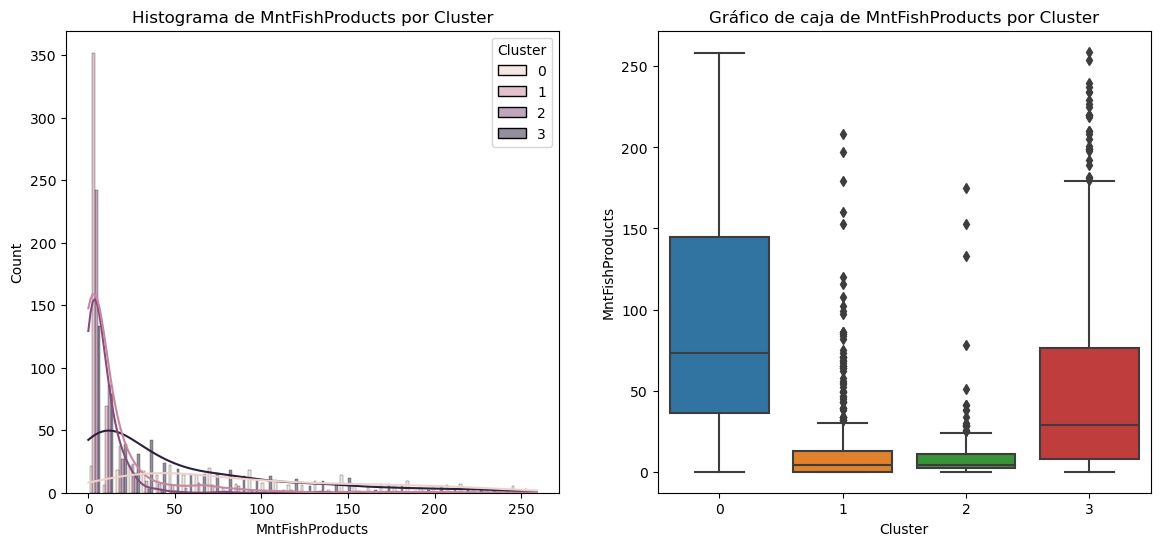

Estadísticos de resumen para MntFishProducts por Cluster:
         count   mean    std  min   25%   50%     75%    max
Cluster                                                     
0        319.0  92.64  68.36  0.0  36.5  73.0  145.00  258.0
1        538.0  12.83  25.19  0.0   0.0   4.0   12.75  208.0
2        381.0   8.60  15.66  0.0   2.0   4.0   11.00  175.0
3        551.0  50.36  57.67  0.0   8.0  29.0   76.50  259.0

ANOVA para MntFishProducts:
Estadístico F: 270.84
p-valor: 0.000
La variable MntFishProducts está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de MntSweetProducts vs Cluster
****************************************


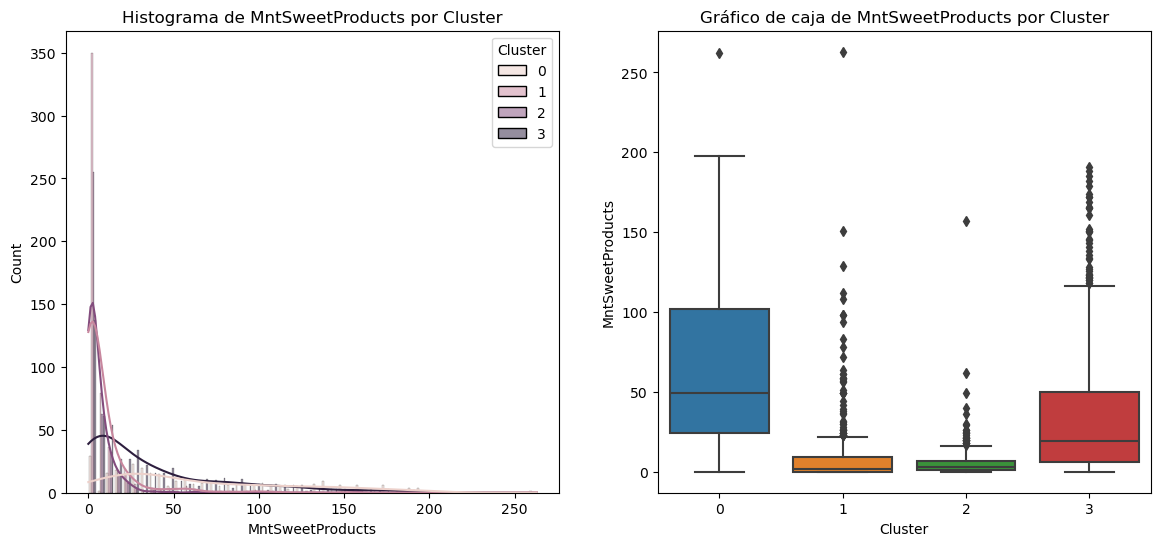

Estadísticos de resumen para MntSweetProducts por Cluster:
         count   mean    std  min   25%   50%    75%    max
Cluster                                                    
0        319.0  66.38  54.34  0.0  24.5  49.0  102.0  262.0
1        538.0   8.81  20.30  0.0   0.0   2.0    9.0  263.0
2        381.0   5.89  10.62  0.0   1.0   3.0    7.0  157.0
3        551.0  36.26  42.30  0.0   6.0  19.0   50.0  191.0

ANOVA para MntSweetProducts:
Estadístico F: 241.93
p-valor: 0.000
La variable MntSweetProducts está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de MntGoldProds vs Cluster
****************************************


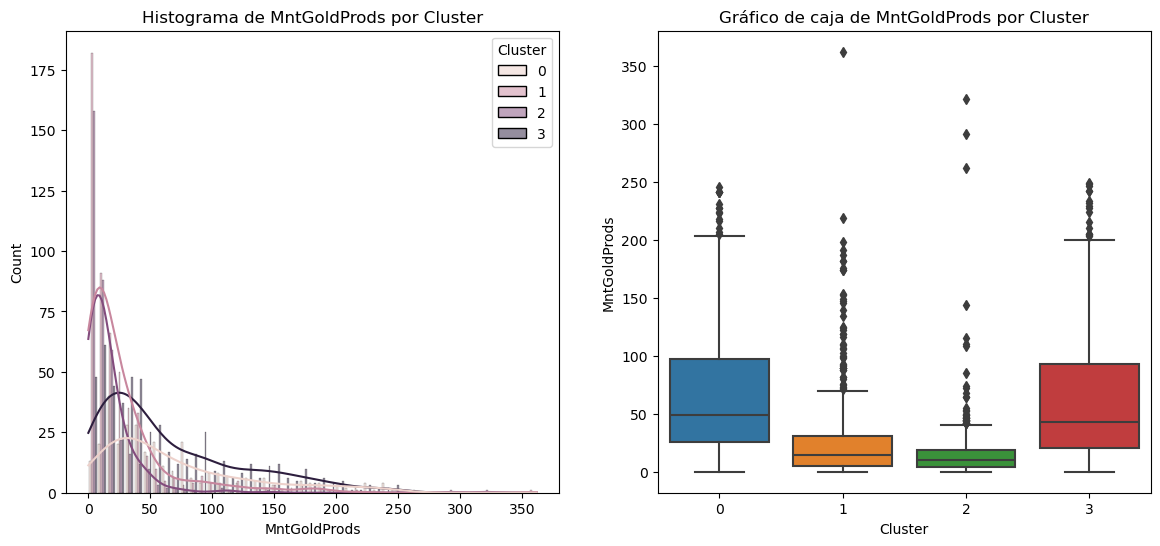

Estadísticos de resumen para MntGoldProds por Cluster:
         count   mean    std  min   25%   50%   75%    max
Cluster                                                   
0        319.0  68.70  58.93  0.0  26.0  49.0  97.0  245.0
1        538.0  26.75  37.75  0.0   5.0  14.0  31.0  362.0
2        381.0  17.17  30.25  0.0   4.0  10.0  19.0  321.0
3        551.0  63.89  57.39  0.0  20.5  43.0  93.0  249.0

ANOVA para MntGoldProds:
Estadístico F: 125.06
p-valor: 0.000
La variable MntGoldProds está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de NumDealsPurchases vs Cluster
****************************************


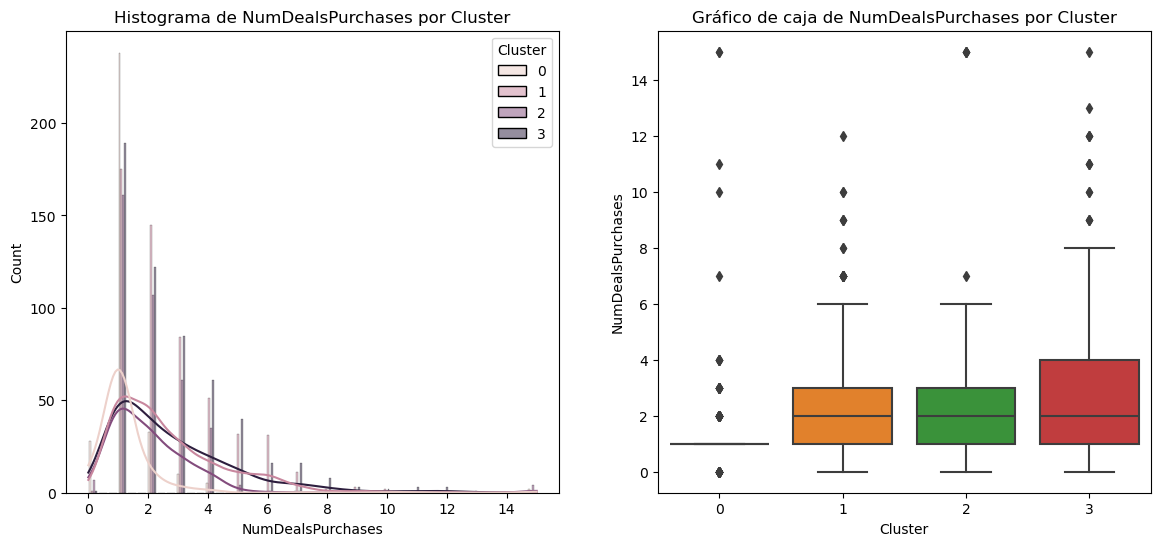

Estadísticos de resumen para NumDealsPurchases por Cluster:
         count  mean   std  min  25%  50%  75%   max
Cluster                                             
0        319.0  1.29  1.51  0.0  1.0  1.0  1.0  15.0
1        538.0  2.64  1.81  0.0  1.0  2.0  3.0  12.0
2        381.0  2.08  1.73  0.0  1.0  2.0  3.0  15.0
3        551.0  2.81  2.16  0.0  1.0  2.0  4.0  15.0

ANOVA para NumDealsPurchases:
Estadístico F: 52.44
p-valor: 0.000
La variable NumDealsPurchases está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de NumWebPurchases vs Cluster
****************************************


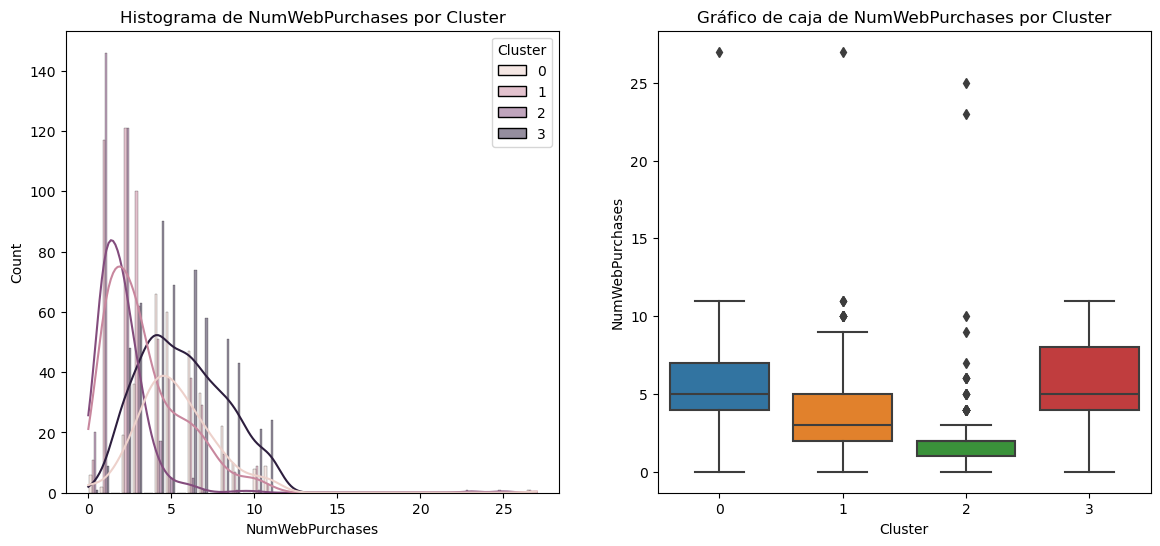

Estadísticos de resumen para NumWebPurchases por Cluster:
         count  mean   std  min  25%  50%  75%   max
Cluster                                             
0        319.0  5.32  2.55  0.0  4.0  5.0  7.0  27.0
1        538.0  3.35  2.52  0.0  2.0  3.0  5.0  27.0
2        381.0  2.02  2.04  0.0  1.0  2.0  2.0  25.0
3        551.0  5.66  2.54  0.0  4.0  5.0  8.0  11.0

ANOVA para NumWebPurchases:
Estadístico F: 210.45
p-valor: 0.000
La variable NumWebPurchases está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de NumCatalogPurchases vs Cluster
****************************************


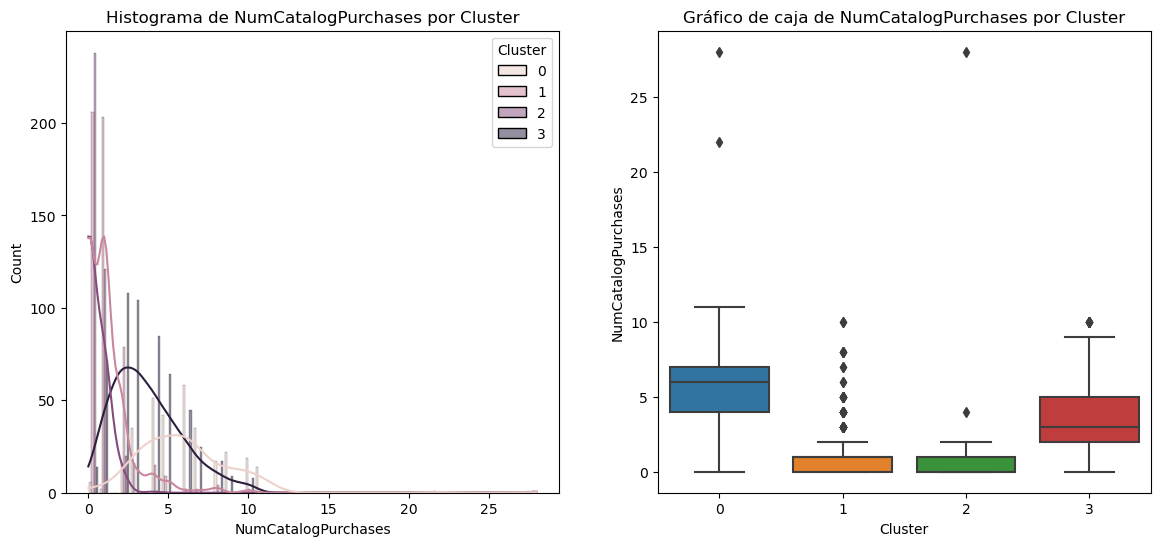

Estadísticos de resumen para NumCatalogPurchases por Cluster:
         count  mean   std  min  25%  50%  75%   max
Cluster                                             
0        319.0  5.87  2.95  0.0  4.0  6.0  7.0  28.0
1        538.0  1.10  1.43  0.0  0.0  1.0  1.0  10.0
2        381.0  0.51  1.54  0.0  0.0  0.0  1.0  28.0
3        551.0  3.63  2.17  0.0  2.0  3.0  5.0  10.0

ANOVA para NumCatalogPurchases:
Estadístico F: 556.38
p-valor: 0.000
La variable NumCatalogPurchases está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de NumStorePurchases vs Cluster
****************************************


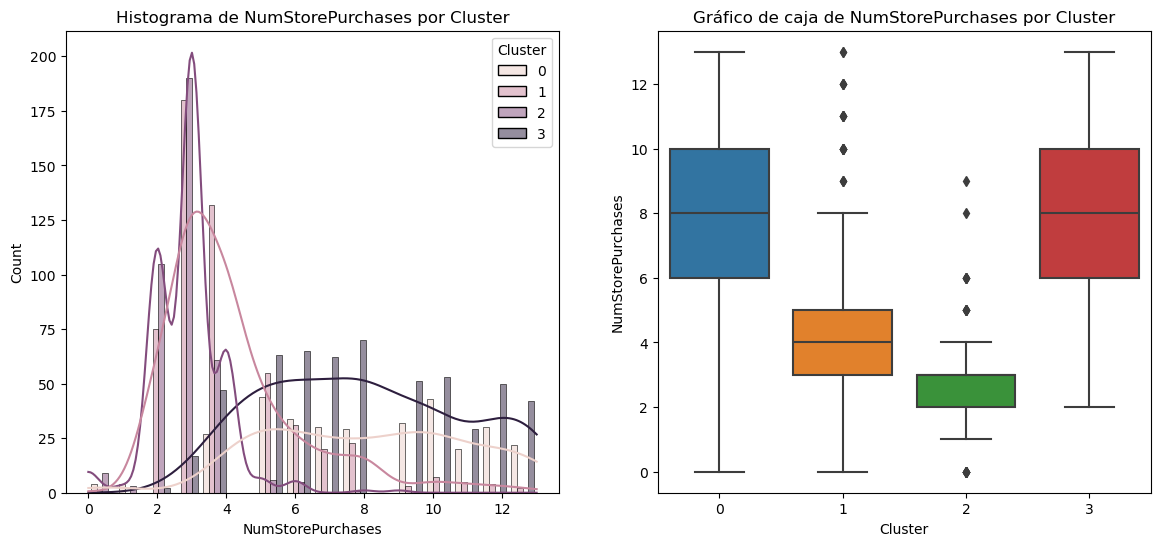

Estadísticos de resumen para NumStorePurchases por Cluster:
         count  mean   std  min  25%  50%   75%   max
Cluster                                              
0        319.0  8.03  3.00  0.0  6.0  8.0  10.0  13.0
1        538.0  4.14  2.02  0.0  3.0  4.0   5.0  13.0
2        381.0  2.90  1.01  0.0  2.0  3.0   3.0   9.0
3        551.0  7.98  2.86  2.0  6.0  8.0  10.0  13.0

ANOVA para NumStorePurchases:
Estadístico F: 530.86
p-valor: 0.000
La variable NumStorePurchases está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de NumWebVisitsMonth vs Cluster
****************************************


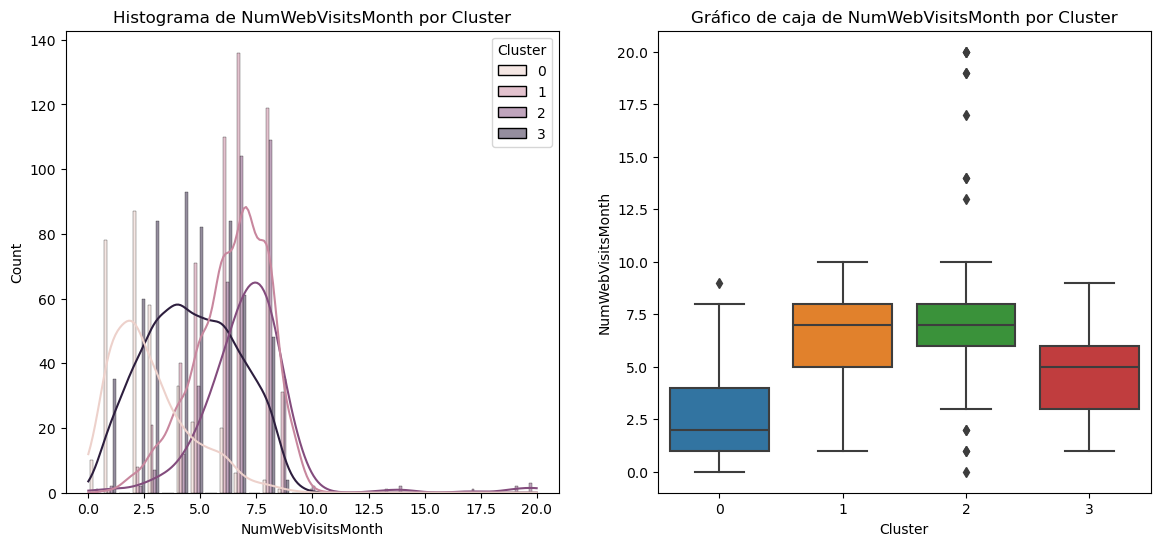

Estadísticos de resumen para NumWebVisitsMonth por Cluster:
         count  mean   std  min  25%  50%  75%   max
Cluster                                             
0        319.0  2.73  1.77  0.0  1.0  2.0  4.0   9.0
1        538.0  6.41  1.61  1.0  5.0  7.0  8.0  10.0
2        381.0  7.14  2.22  0.0  6.0  7.0  8.0  20.0
3        551.0  4.61  2.03  1.0  3.0  5.0  6.0   9.0

ANOVA para NumWebVisitsMonth:
Estadístico F: 393.12
p-valor: 0.000
La variable NumWebVisitsMonth está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de AcceptedCmp3 vs Cluster
****************************************


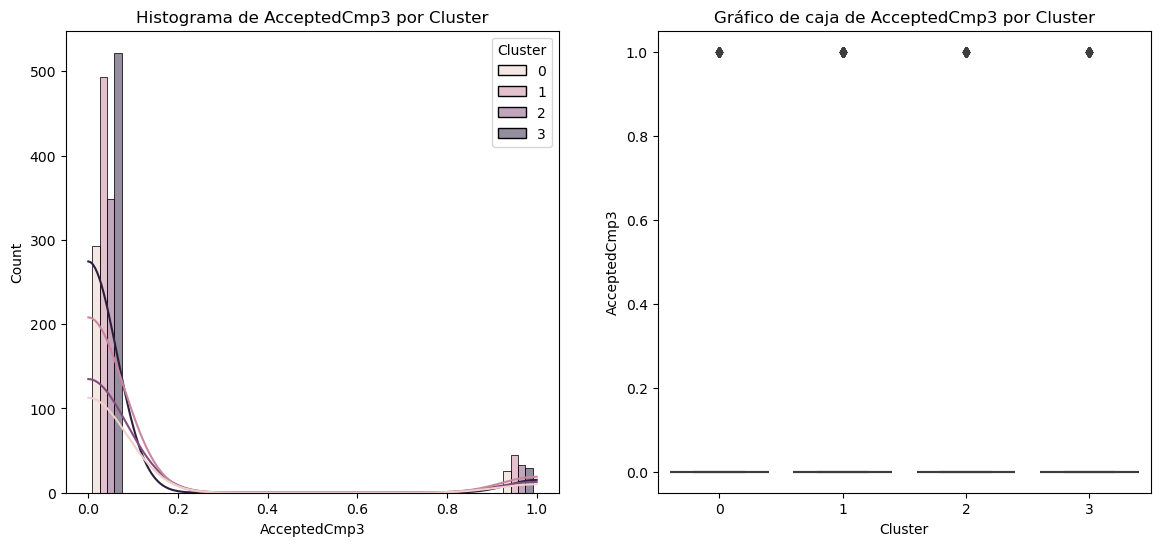

Estadísticos de resumen para AcceptedCmp3 por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        319.0  0.08  0.27  0.0  0.0  0.0  0.0  1.0
1        538.0  0.08  0.28  0.0  0.0  0.0  0.0  1.0
2        381.0  0.09  0.28  0.0  0.0  0.0  0.0  1.0
3        551.0  0.05  0.22  0.0  0.0  0.0  0.0  1.0

ANOVA para AcceptedCmp3:
Estadístico F: 1.84
p-valor: 0.137
La variable AcceptedCmp3 no está significativamente asociada con Cluster (p >= 0.05).

Análisis de AcceptedCmp4 vs Cluster
****************************************


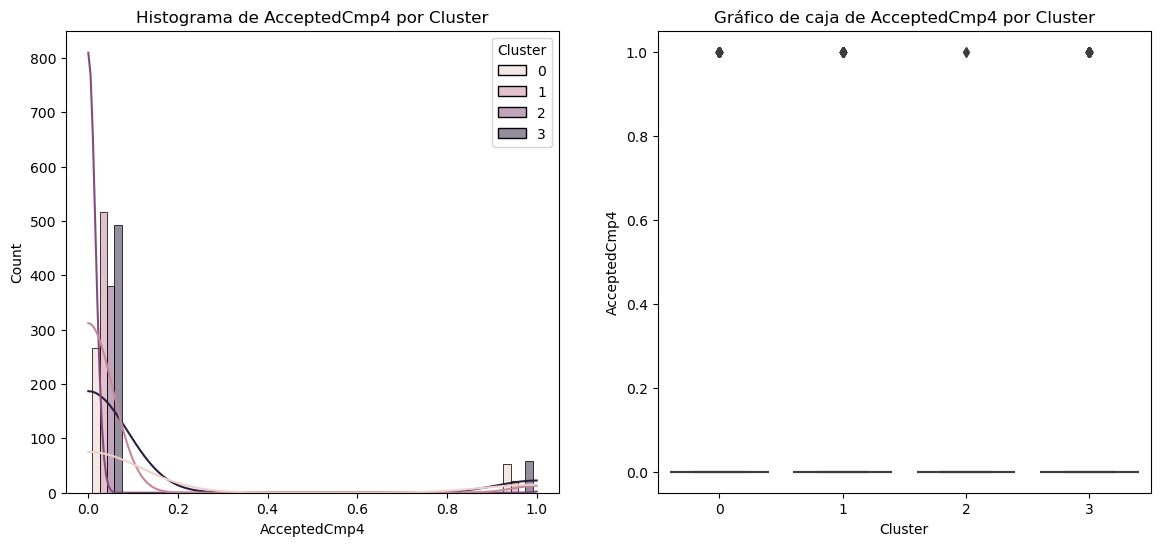

Estadísticos de resumen para AcceptedCmp4 por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        319.0  0.17  0.37  0.0  0.0  0.0  0.0  1.0
1        538.0  0.04  0.19  0.0  0.0  0.0  0.0  1.0
2        381.0  0.00  0.05  0.0  0.0  0.0  0.0  1.0
3        551.0  0.11  0.31  0.0  0.0  0.0  0.0  1.0

ANOVA para AcceptedCmp4:
Estadístico F: 29.78
p-valor: 0.000
La variable AcceptedCmp4 está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de AcceptedCmp5 vs Cluster
****************************************


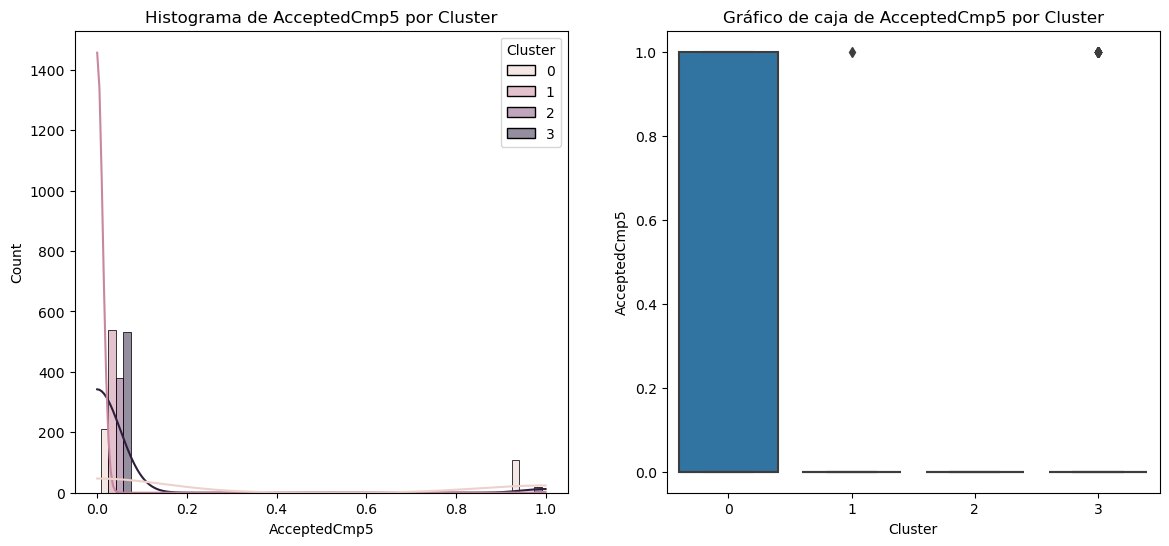

Estadísticos de resumen para AcceptedCmp5 por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        319.0  0.34  0.47  0.0  0.0  0.0  1.0  1.0
1        538.0  0.00  0.04  0.0  0.0  0.0  0.0  1.0
2        381.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0
3        551.0  0.03  0.18  0.0  0.0  0.0  0.0  1.0

ANOVA para AcceptedCmp5:
Estadístico F: 183.94
p-valor: 0.000
La variable AcceptedCmp5 está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de AcceptedCmp1 vs Cluster
****************************************


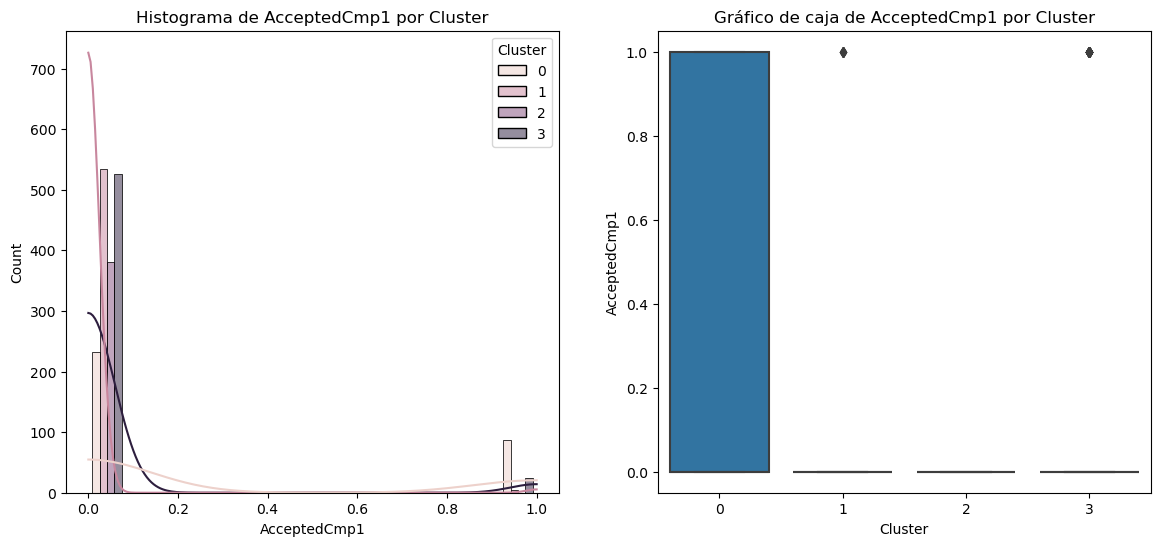

Estadísticos de resumen para AcceptedCmp1 por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        319.0  0.27  0.45  0.0  0.0  0.0  1.0  1.0
1        538.0  0.01  0.09  0.0  0.0  0.0  0.0  1.0
2        381.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0
3        551.0  0.05  0.21  0.0  0.0  0.0  0.0  1.0

ANOVA para AcceptedCmp1:
Estadístico F: 113.44
p-valor: 0.000
La variable AcceptedCmp1 está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de AcceptedCmp2 vs Cluster
****************************************


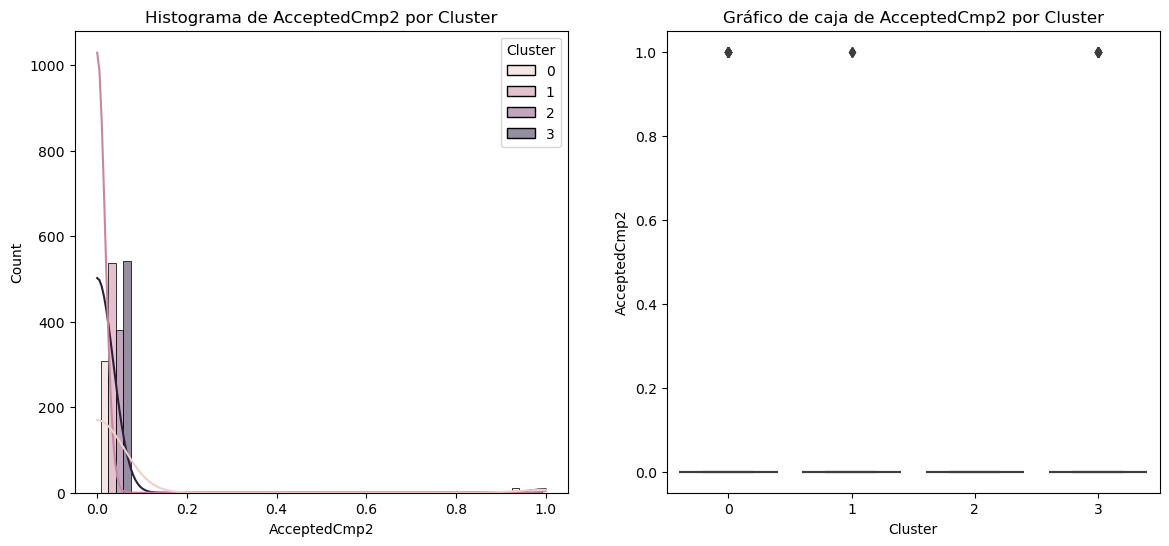

Estadísticos de resumen para AcceptedCmp2 por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        319.0  0.04  0.19  0.0  0.0  0.0  0.0  1.0
1        538.0  0.00  0.06  0.0  0.0  0.0  0.0  1.0
2        381.0  0.00  0.00  0.0  0.0  0.0  0.0  0.0
3        551.0  0.02  0.13  0.0  0.0  0.0  0.0  1.0

ANOVA para AcceptedCmp2:
Estadístico F: 8.24
p-valor: 0.000
La variable AcceptedCmp2 está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de Complain vs Cluster
****************************************


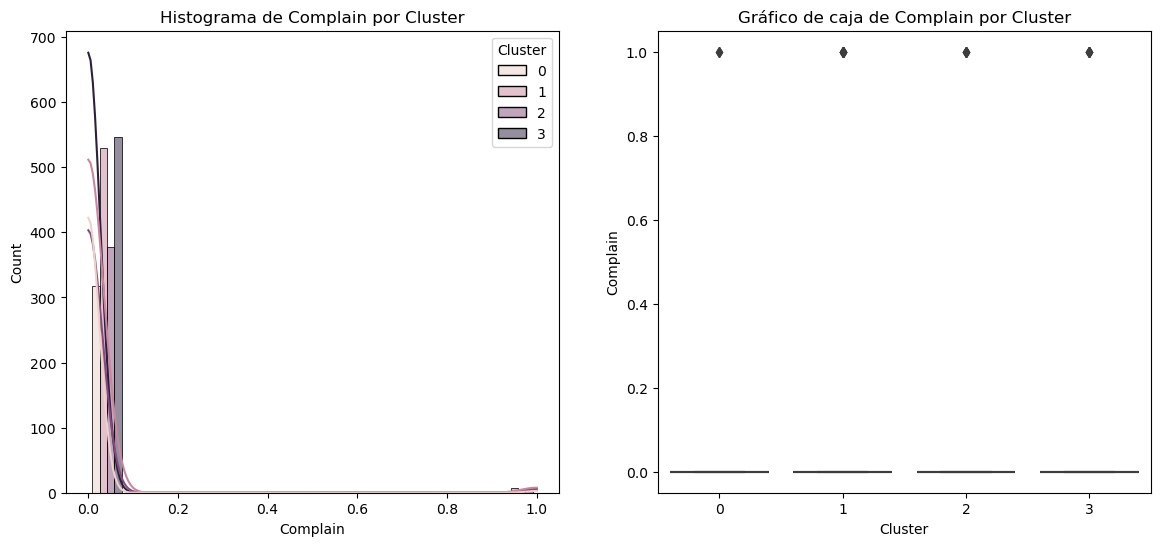

Estadísticos de resumen para Complain por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        319.0  0.01  0.08  0.0  0.0  0.0  0.0  1.0
1        538.0  0.01  0.12  0.0  0.0  0.0  0.0  1.0
2        381.0  0.01  0.10  0.0  0.0  0.0  0.0  1.0
3        551.0  0.01  0.09  0.0  0.0  0.0  0.0  1.0

ANOVA para Complain:
Estadístico F: 0.54
p-valor: 0.654
La variable Complain no está significativamente asociada con Cluster (p >= 0.05).

Análisis de Response vs Cluster
****************************************


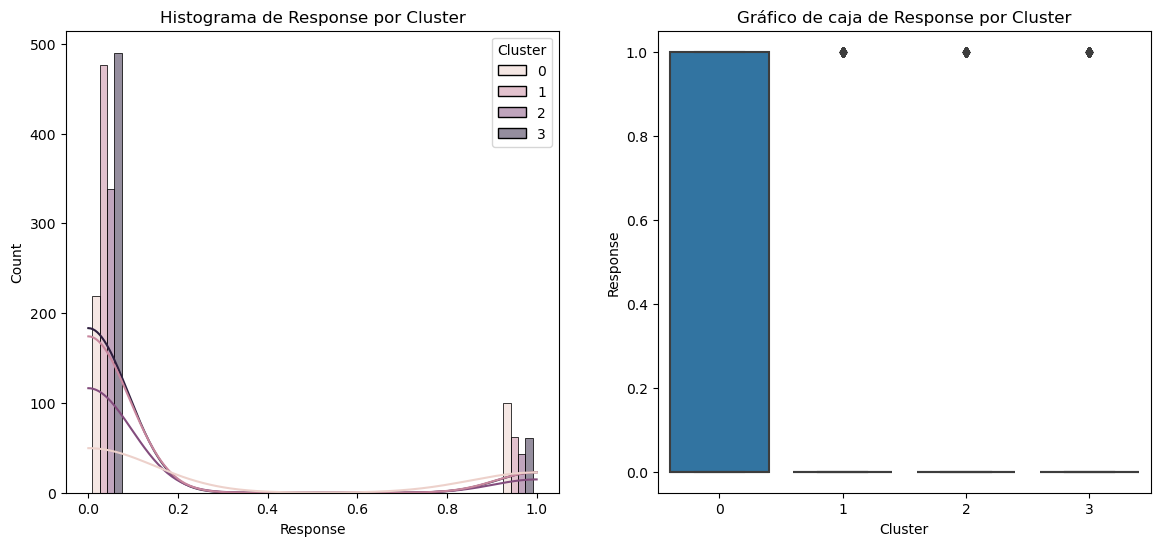

Estadísticos de resumen para Response por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        319.0  0.31  0.46  0.0  0.0  0.0  1.0  1.0
1        538.0  0.12  0.32  0.0  0.0  0.0  0.0  1.0
2        381.0  0.11  0.32  0.0  0.0  0.0  0.0  1.0
3        551.0  0.11  0.31  0.0  0.0  0.0  0.0  1.0

ANOVA para Response:
Estadístico F: 29.07
p-valor: 0.000
La variable Response está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de age vs Cluster
****************************************


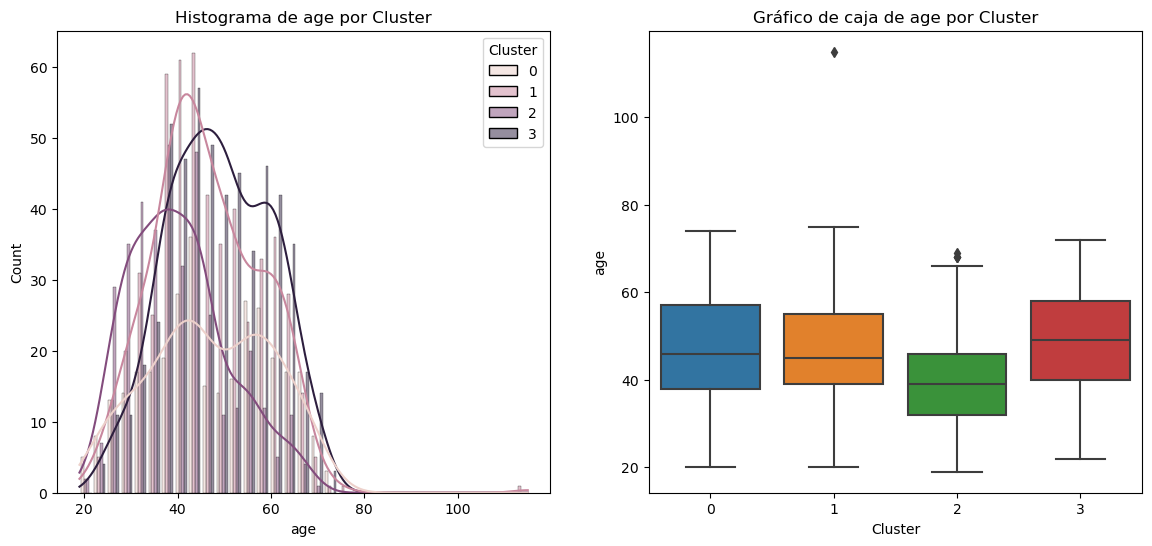

Estadísticos de resumen para age por Cluster:
         count   mean    std   min   25%   50%   75%    max
Cluster                                                    
0        319.0  47.04  13.12  20.0  38.0  46.0  57.0   74.0
1        538.0  46.32  11.44  20.0  39.0  45.0  55.0  115.0
2        381.0  40.33  10.50  19.0  32.0  39.0  46.0   69.0
3        551.0  48.91  10.89  22.0  40.0  49.0  58.0   72.0

ANOVA para age:
Estadístico F: 44.31
p-valor: 0.000
La variable age está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de customes_seniority vs Cluster
****************************************


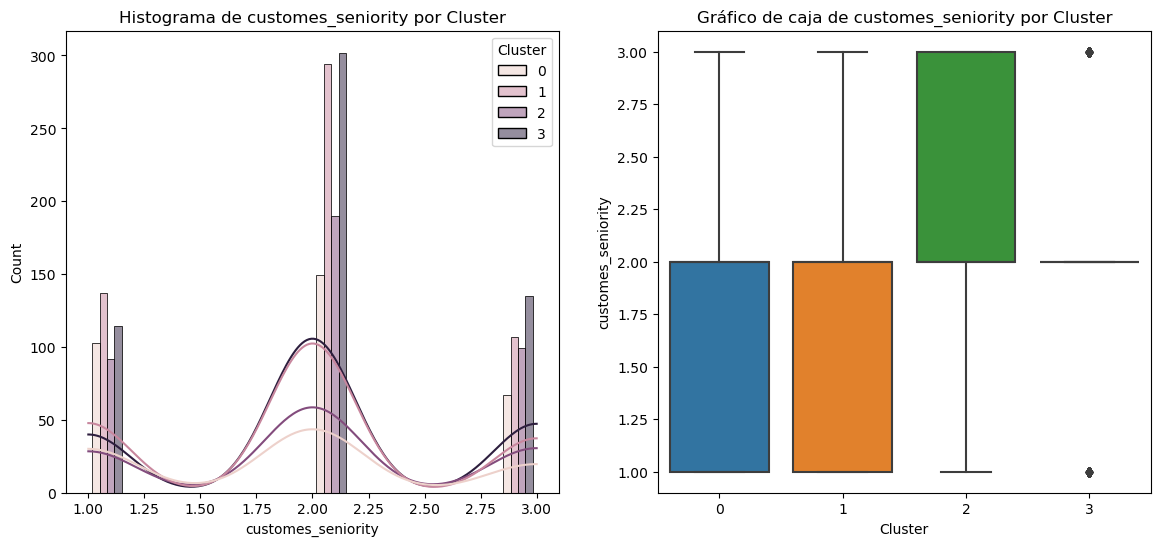

Estadísticos de resumen para customes_seniority por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        319.0  1.89  0.72  1.0  1.0  2.0  2.0  3.0
1        538.0  1.94  0.67  1.0  1.0  2.0  2.0  3.0
2        381.0  2.02  0.71  1.0  2.0  2.0  3.0  3.0
3        551.0  2.04  0.67  1.0  2.0  2.0  2.0  3.0

ANOVA para customes_seniority:
Estadístico F: 4.11
p-valor: 0.006
La variable customes_seniority está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de Household_members vs Cluster
****************************************


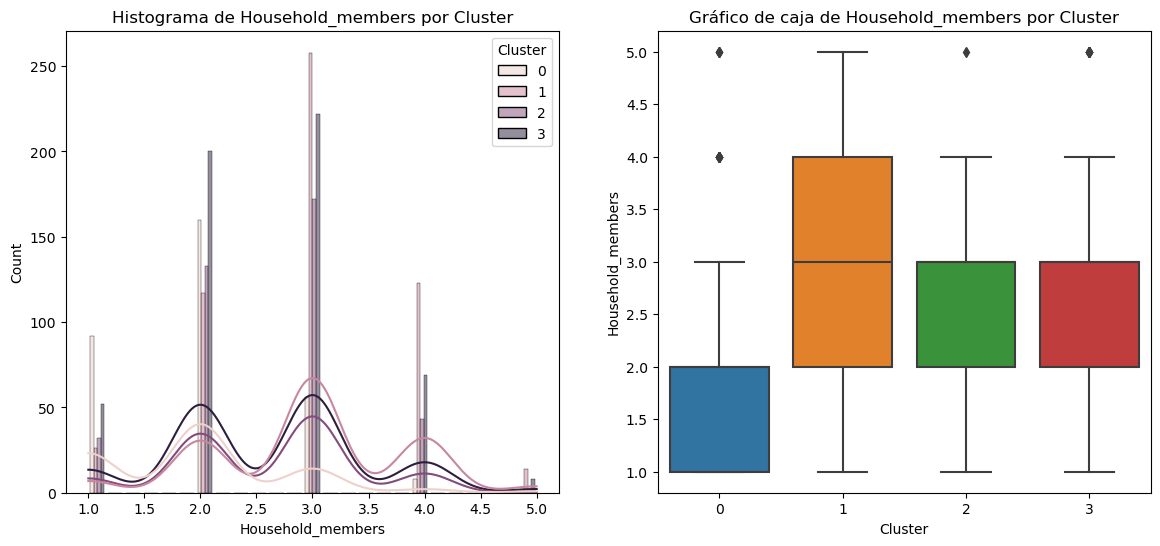

Estadísticos de resumen para Household_members por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        319.0  1.97  0.81  1.0  1.0  2.0  2.0  5.0
1        538.0  2.97  0.86  1.0  2.0  3.0  4.0  5.0
2        381.0  2.60  0.81  1.0  2.0  3.0  3.0  5.0
3        551.0  2.60  0.88  1.0  2.0  3.0  3.0  5.0

ANOVA para Household_members:
Estadístico F: 93.63
p-valor: 0.000
La variable Household_members está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de Total_amount vs Cluster
****************************************


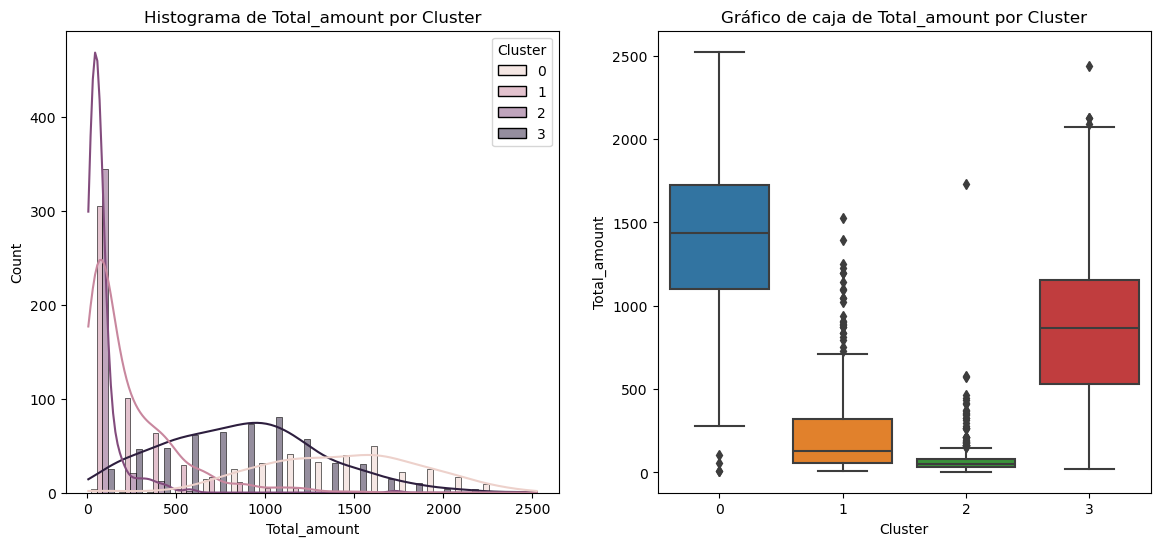

Estadísticos de resumen para Total_amount por Cluster:
         count     mean     std   min     25%     50%      75%     max
Cluster                                                               
0        319.0  1415.32  452.06   6.0  1102.5  1435.0  1722.00  2524.0
1        538.0   225.86  245.37  11.0    55.5   131.0   317.75  1526.0
2        381.0    79.64  119.14   5.0    31.0    52.0    79.00  1730.0
3        551.0   866.08  444.52  18.0   530.0   868.0  1151.50  2440.0

ANOVA para Total_amount:
Estadístico F: 1208.95
p-valor: 0.000
La variable Total_amount está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de Total_purchase vs Cluster
****************************************


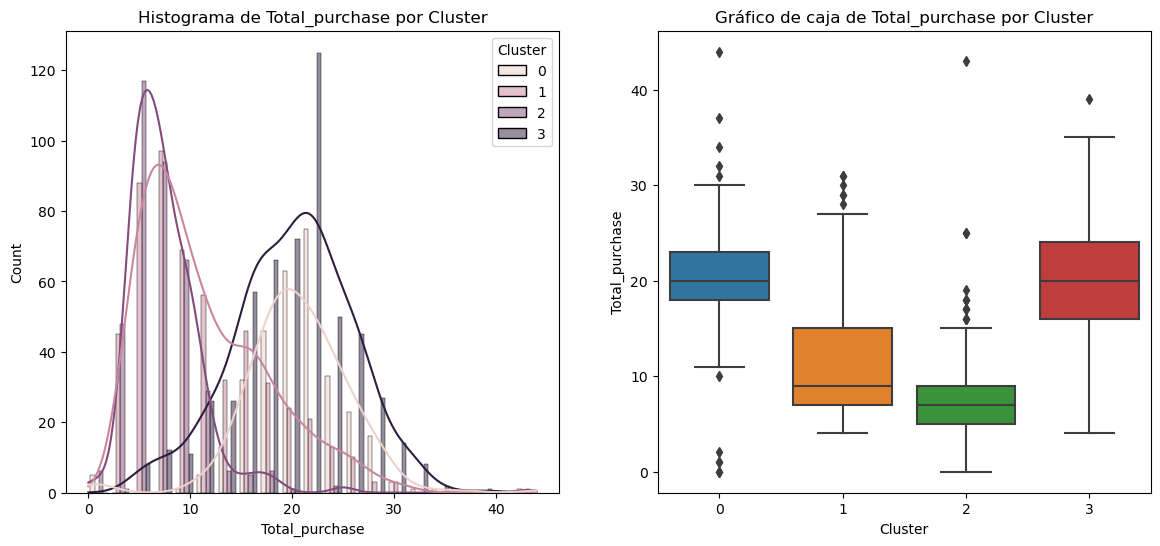

Estadísticos de resumen para Total_purchase por Cluster:
         count   mean   std  min   25%   50%   75%   max
Cluster                                                 
0        319.0  20.52  5.12  0.0  18.0  20.0  23.0  44.0
1        538.0  11.23  6.05  4.0   7.0   9.0  15.0  31.0
2        381.0   7.50  3.72  0.0   5.0   7.0   9.0  43.0
3        551.0  20.08  5.76  4.0  16.0  20.0  24.0  39.0

ANOVA para Total_purchase:
Estadístico F: 611.81
p-valor: 0.000
La variable Total_purchase está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Análisis de Total_cmp vs Cluster
****************************************


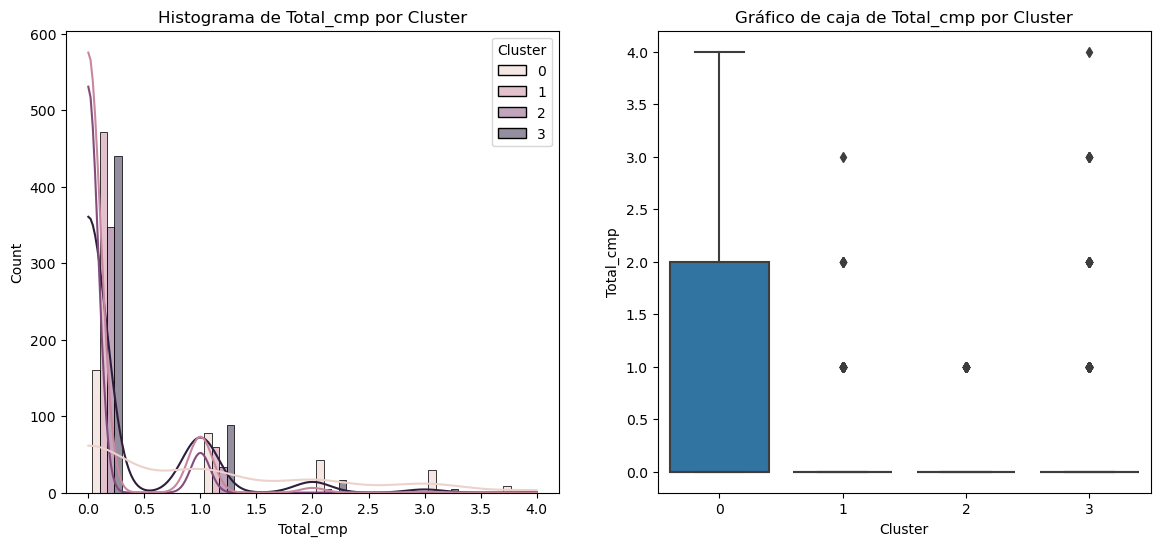

Estadísticos de resumen para Total_cmp por Cluster:
         count  mean   std  min  25%  50%  75%  max
Cluster                                            
0        319.0  0.90  1.11  0.0  0.0  0.0  2.0  4.0
1        538.0  0.14  0.38  0.0  0.0  0.0  0.0  3.0
2        381.0  0.09  0.29  0.0  0.0  0.0  0.0  1.0
3        551.0  0.26  0.57  0.0  0.0  0.0  0.0  4.0

ANOVA para Total_cmp:
Estadístico F: 127.31
p-valor: 0.000
La variable Total_cmp está significativamente asociada con Cluster (p < 0.05). Podría ser útil para el modelo.

Las features correlacionadas son: ['Income', 'Kidhome', 'Teenhome', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response', 'age', 'customes_seniority', 'Household_members', 'Total_amount', 'Total_purchase', 'Total_cmp']
Las features NO cor

In [12]:
target = 'Cluster'

analisis_bivariable_numericas_categorica(train_set,target,features_num)

### Análisis con las variables categóricas

Análisis de Education vs Cluster
****************************************


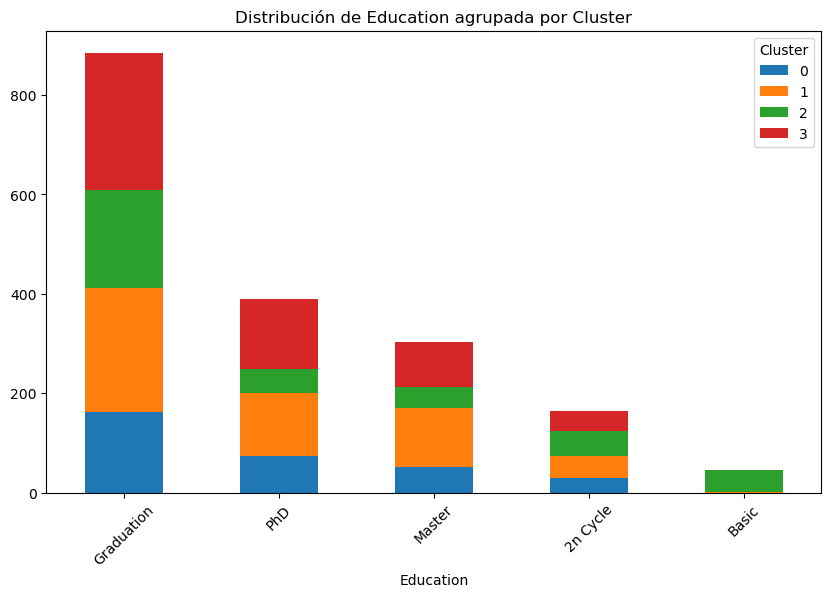

Tabla de contingencia de Education vs Cluster:
Cluster       0    1    2    3
Education                     
Graduation  163  248  197  277
PhD          74  127   47  141
Master       52  119   41   92
2n Cycle     30   43   51   41
Basic         0    1   45    0

Tabla de porcentajes de Education respecto a Cluster:
Cluster             0          1          2          3
Education                                             
Graduation  51.097179  46.096654  51.706037  50.272232
PhD         23.197492  23.605948  12.335958  25.589837
Master      16.300940  22.118959  10.761155  16.696915
2n Cycle     9.404389   7.992565  13.385827   7.441016
Basic        0.000000   0.185874  11.811024   0.000000

Tabla de frecuencias para Education:
            Frecuencia Absoluta  Frecuencia Relativa (%)
Education                                               
Graduation                  885                49.468977
PhD                         389                21.743991
Master                      30

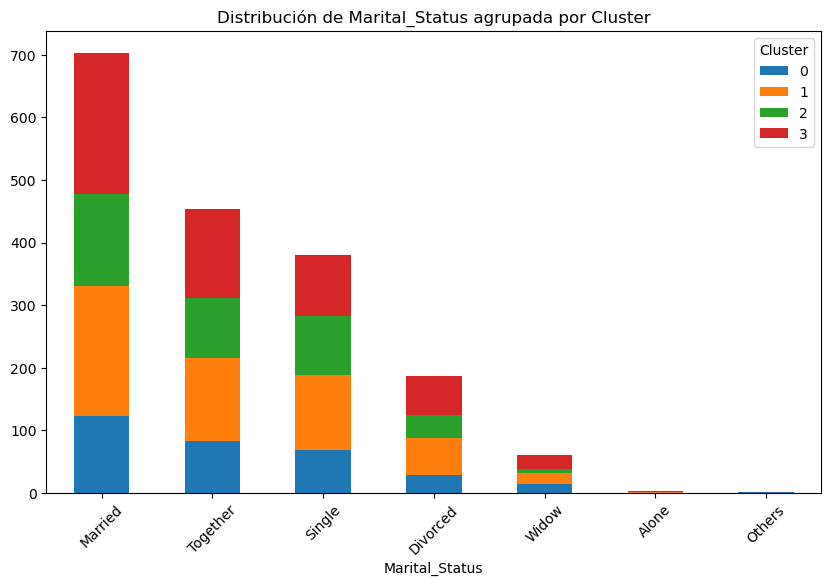

Tabla de contingencia de Marital_Status vs Cluster:
Cluster           0    1    2    3
Marital_Status                    
Married         123  207  147  226
Together         83  133   95  142
Single           69  120   94   97
Divorced         29   58   38   62
Widow            14   18    7   22
Alone             0    2    0    1
Others            1    0    0    1

Tabla de porcentajes de Marital_Status respecto a Cluster:
Cluster                 0          1          2          3
Marital_Status                                            
Married         38.557994  38.475836  38.582677  41.016334
Together        26.018809  24.721190  24.934383  25.771325
Single          21.630094  22.304833  24.671916  17.604356
Divorced         9.090909  10.780669   9.973753  11.252269
Widow            4.388715   3.345725   1.837270   3.992740
Alone            0.000000   0.371747   0.000000   0.181488
Others           0.313480   0.000000   0.000000   0.181488

Tabla de frecuencias para Marital_Status:

In [13]:
analisis_bivariable_categoricas_categorica(train_set,target,features_cat)

### Otros análisis

In [14]:
cluster_0 = train_set.loc[train_set['Cluster']==0]
cluster_0.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Income,319.0,83115.62,12126.59,73059.0,77261.5,80589.0,85251.5,162397.0
Kidhome,319.0,0.07,0.26,0.0,0.0,0.0,0.0,1.0
Teenhome,319.0,0.25,0.48,0.0,0.0,0.0,0.0,2.0
Recency,319.0,49.39,30.29,0.0,23.0,51.0,76.0,99.0
MntWines,319.0,657.19,340.29,1.0,410.0,611.0,904.5,1493.0
MntFruits,319.0,63.93,50.65,0.0,22.0,50.0,98.0,194.0
MntMeatProducts,319.0,466.49,261.59,1.0,275.0,430.0,627.0,1622.0
MntFishProducts,319.0,92.64,68.36,0.0,36.5,73.0,145.0,258.0
MntSweetProducts,319.0,66.38,54.34,0.0,24.5,49.0,102.0,262.0
MntGoldProds,319.0,68.70,58.93,0.0,26.0,49.0,97.0,245.0


In [15]:
cluster_0['Marital_Status'].value_counts(normalize=True).round(2)

Marital_Status
Married     0.39
Together    0.26
Single      0.22
Divorced    0.09
Widow       0.04
Others      0.00
Alone       0.00
Name: proportion, dtype: float64

In [16]:
cluster_0['Education'].value_counts(normalize=True).round(2)

Education
Graduation    0.51
PhD           0.23
Master        0.16
2n Cycle      0.09
Basic         0.00
Name: proportion, dtype: float64

In [17]:
cluster_1 = train_set.loc[train_set['Cluster']==1]
cluster_1.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Income,538.0,42045.16,5685.35,32727.0,36968.50,42012.5,46723.50,52413.0
Kidhome,538.0,0.69,0.54,0.0,0.00,1.0,1.00,2.0
Teenhome,538.0,0.65,0.54,0.0,0.00,1.0,1.00,2.0
Recency,538.0,49.43,29.04,0.0,24.25,49.0,75.00,99.0
MntWines,538.0,122.57,164.58,2.0,23.00,57.0,162.75,1181.0
MntFruits,538.0,7.92,15.68,0.0,0.00,3.0,8.00,133.0
MntMeatProducts,538.0,46.98,52.17,1.0,12.00,26.0,62.75,271.0
MntFishProducts,538.0,12.83,25.19,0.0,0.00,4.0,12.75,208.0
MntSweetProducts,538.0,8.81,20.30,0.0,0.00,2.0,9.00,263.0
MntGoldProds,538.0,26.75,37.75,0.0,5.00,14.0,31.00,362.0


In [18]:
cluster_1['Marital_Status'].value_counts(normalize=True).round(2)

Marital_Status
Married     0.38
Together    0.25
Single      0.22
Divorced    0.11
Widow       0.03
Alone       0.00
Others      0.00
Name: proportion, dtype: float64

In [19]:
cluster_1['Education'].value_counts(normalize=True).round(2)

Education
Graduation    0.46
PhD           0.24
Master        0.22
2n Cycle      0.08
Basic         0.00
Name: proportion, dtype: float64

In [20]:
cluster_2 = train_set.loc[train_set['Cluster']==2]
cluster_2.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Income,381.0,23259.97,6909.78,1730.0,19107.0,24336.0,28691.0,32644.0
Kidhome,381.0,0.77,0.47,0.0,0.0,1.0,1.0,2.0
Teenhome,381.0,0.19,0.40,0.0,0.0,0.0,0.0,2.0
Recency,381.0,48.14,28.43,0.0,24.0,47.0,75.0,99.0
MntWines,381.0,18.92,32.01,0.0,4.0,9.0,19.0,284.0
MntFruits,381.0,6.04,11.41,0.0,1.0,3.0,7.0,151.0
MntMeatProducts,381.0,23.03,91.05,0.0,7.0,11.0,20.0,1725.0
MntFishProducts,381.0,8.60,15.66,0.0,2.0,4.0,11.0,175.0
MntSweetProducts,381.0,5.89,10.62,0.0,1.0,3.0,7.0,157.0
MntGoldProds,381.0,17.17,30.25,0.0,4.0,10.0,19.0,321.0


In [21]:
cluster_2['Marital_Status'].value_counts(normalize=True).round(2)

Marital_Status
Married     0.39
Together    0.25
Single      0.25
Divorced    0.10
Widow       0.02
Alone       0.00
Others      0.00
Name: proportion, dtype: float64

In [22]:
cluster_2['Education'].value_counts(normalize=True).round(2)

Education
Graduation    0.52
2n Cycle      0.13
PhD           0.12
Basic         0.12
Master        0.11
Name: proportion, dtype: float64

In [23]:
cluster_3 = train_set.loc[train_set['Cluster']==3]
cluster_3.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Income,551.0,62861.23,5932.39,52513.0,57718.0,62998.0,68001.5,72967.0
Kidhome,551.0,0.21,0.44,0.0,0.0,0.0,0.0,2.0
Teenhome,551.0,0.73,0.52,0.0,0.0,1.0,1.0,2.0
Recency,551.0,49.15,28.63,0.0,25.0,51.0,73.0,99.0
MntWines,551.0,471.38,292.66,5.0,242.0,418.0,630.0,1462.0
MntFruits,551.0,36.16,42.17,0.0,6.0,21.0,52.0,199.0
MntMeatProducts,551.0,208.03,181.40,3.0,75.5,151.0,278.5,932.0
MntFishProducts,551.0,50.36,57.67,0.0,8.0,29.0,76.5,259.0
MntSweetProducts,551.0,36.26,42.30,0.0,6.0,19.0,50.0,191.0
MntGoldProds,551.0,63.89,57.39,0.0,20.5,43.0,93.0,249.0


In [24]:
cluster_3['Marital_Status'].value_counts(normalize=True).round(2)

Marital_Status
Married     0.41
Together    0.26
Single      0.18
Divorced    0.11
Widow       0.04
Alone       0.00
Others      0.00
Name: proportion, dtype: float64

In [25]:
cluster_3['Education'].value_counts(normalize=True).round(2)

Education
Graduation    0.50
PhD           0.26
Master        0.17
2n Cycle      0.07
Basic         0.00
Name: proportion, dtype: float64

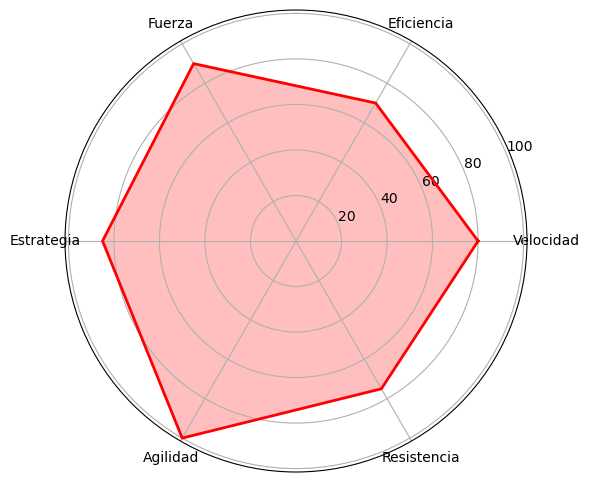

In [26]:
# Ejemplo gráfico de radar dado por chatGPT

# Número de variables que estamos graficando.
num_vars = 6

# Dividir el círculo y calcular los ángulos necesarios para representar cada eje.
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Los datos del gráfico de radar.
stats = [80, 70, 90, 85, 100, 75]

# El gráfico es circular, por lo que necesitamos cerrar el círculo y los ángulos deben completarse.
stats += stats[:1]
angles += angles[:1]

# Iniciar el gráfico de radar.
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Dibujar una línea alrededor del gráfico de radar.
ax.fill(angles, stats, color='red', alpha=0.25)

# Dibujar las líneas de los ejes.
ax.plot(angles, stats, color='red', linewidth=2)

# Definir la ubicación de las etiquetas de los ejes.
labels = ['Velocidad', 'Eficiencia', 'Fuerza', 'Estrategia', 'Agilidad', 'Resistencia']

# Establecer las etiquetas para los ejes.
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Mostrar el gráfico.
plt.show()